# Отбор признаков и снижение размерности

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Понижение размерности можно использовать для следующих целей:

* Сокращение ресурсоемкости алгоритмов
* Ослабление влияния проклятия размерности и тем самым уменьшение переобучения
* Переход к более информативным признакам

Сейчас мы будем понижать размерность ориентируясь как раз на эти цели.
Тогда этот процесс также можно называть и выделением признаков.

## Отбор признаков

Мы можем сократить количество исходных признаков несколькими способами. Первый - на основе **корреляции с целевой переменной**.

(506, 14)


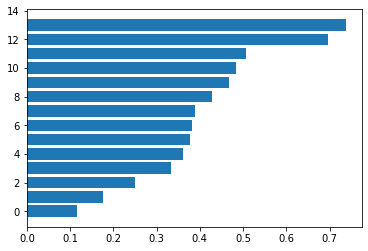

In [2]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

ds = load_boston()
X_, y = ds.data, ds.target

#добавим "мешающий" признак
X = np.zeros((X_.shape[0],X_.shape[1]+1))
X[:,:-1] = X_
curr = np.random.randint(2, size=506)
curr = np.array([elem if elem > 0 else elem-1 for elem in curr])
X[:,-1] = X[:,0]*curr
print(X.shape)

indices = np.arange(len(y))
np.random.shuffle(indices)
X = X[indices, :]
y = y[indices]

features_ind = np.arange(X.shape[1])
corrs = np.abs([np.corrcoef(X[:, i], y)[0][1] for i in features_ind])
importances_sort = np.argsort(corrs)
plt.barh(features_ind, corrs[importances_sort])
X = X[:, importances_sort]

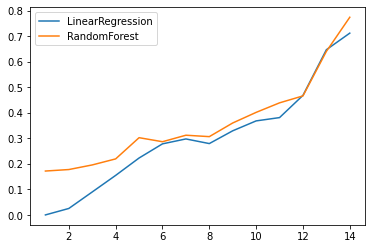

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

features_counts = np.arange(1, X.shape[1] + 1)

def scores_by_features_count(reg):
    scores = []
    for features_part in features_counts:
        X_part = X[:, :features_part]
        scores.append(cross_val_score(reg, X_part, y, cv=3).mean())
    return scores
    
plt.figure()
linreg_scores = scores_by_features_count(LinearRegression())
plt.plot(features_counts, linreg_scores, label='LinearRegression')

rf_scores = scores_by_features_count(RandomForestRegressor(n_estimators=100, max_depth=3))
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best')

Еще один способ отбора признаков - с помощью метода **SelectKBest**. Метод оставляет k признаков с самыми большими значениями некоторой статистики, которую используем для отбора. Приведем пример, в качестве статистики использующий совместную информацию признаков. Для признаков X и Y она задается следующей формулой:

$$I(X;Y)=\sum _{y\in Y}\sum _{x\in X}p(x,y)\log {\left({\frac {p(x,y)}{p(x)\,p(y)}}\right)}$$

In [4]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression

def scores_by_kbest_count(reg):
    scores = []
    for features_part in features_counts:
        X_new = SelectKBest(mutual_info_regression, k=features_part).fit_transform(X, y)
        scores.append(cross_val_score(reg, X_new, y, cv=3).mean())
    return scores
    
#Plot results of SelectKBest
#Your code is here

**Рекурсивный отбор признаков**

Выбираем алгоритм (estimator), применяем его, и он в результате своей работы присваивает веса всем признакам. Затем откидываем наименее важные признаки и снова запускаем estimator и т.д., до тех пор, пока не останется заранее заданное число признаков.

In [5]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, SVR, LinearSVR

def scores_by_rfe_count(reg):
    scores = []
    for features_part in features_counts:
        
        est = LinearRegression()
        #Try another estimators. Which one is the best?
        
        X_rfe = RFE(estimator=est, n_features_to_select=features_part, step=1).fit_transform(X, y)
        scores.append(cross_val_score(reg, X_rfe, y, cv=3).mean())
    return scores
    
#Plot results of RFE
#Your code is here

Мы видим, что последние два метода при использовании RandomForestRegressor позволяют нам оставить довольно мало признаков, что существенно ускоряет нас.

## Метод главных компонент (Principal Component Analysis, PCA)

Выделение новых признаков путем их отбора часто дает плохие результаты, и
в некоторых ситуациях такой подход практически бесполезен. Например, если
мы работаем с изображениями, у которых признаками являются яркости пикселей,
невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о
содержимом картинки. 

Поэтому признаки нужно как-то комбинировать. Рассмотрим метод главных компонент.

Этот метод делает два важных упрощения задачи

1. Игнорируется целевая переменная
2. Строится линейная комбинация признаков

П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является
таким уж плохим. Это связано с тем, что часто данные устроены так, что имеют какую-то
внутреннюю структуру в пространстве меньшей размерности, которая никак не связана с
целевой переменной. Поэтому и оптимальные признаки можно строить не глядя на ответ.

П. 2 тоже сильно упрощает задачу, но далее мы научимся избавляться от него.

### Теория

Обозначим $X$ - матрица объекты-признаки, с нулевым средним каждого признака,
а $w$ - некоторый единичный вектор. Тогда
$Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор,
который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию
вдоль этого направления):

$$
    \max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным
значением. После этого все пространство проецируется на ортогональное дополнение к вектору
$w$ и процесс повторяется.

### PCA на плоскости

Для начала посмотрим на метод PCA на плоскости для того, чтобы
лучше понять, как он устроен.

Создадим выборку из двух сильно зависящих признаков.

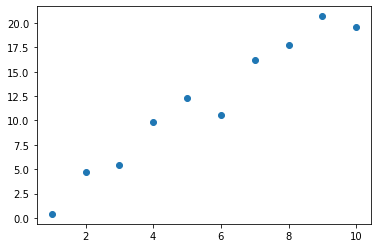

In [6]:
x = np.arange(1,11)
y = 2 * x + np.random.randn(10)*2
X = np.vstack((x,y))

plt.scatter(X[0],X[1])

In [7]:
#Найдите m - вектор со средними значениями X,
#и Xcentered = X-mean (хотим, чтобы среднее по каждой координате стало 0)
#Your code is here
Xcentered = ...
m = ...

print("Mean vector: ", m)
print(Xcentered)

plt.scatter(Xcentered[0],Xcentered[1])

Mean vector:  Ellipsis
Ellipsis


TypeError: 'ellipsis' object is not subscriptable

Проверим, что нам выдаст PCA из sklearn

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_pca = pca.fit_transform(Xcentered.T) #в задачах с табличными данными T не нужно.

# PCA.fit - обучение
# PCA.transform - применение метода
# PCA.fit_transform - обучение+применение
X_pca.shape, Xcentered.shape

Посмотрим на главные компоненты.

In [ ]:
print(pca.components_)

Доля объясненного разброса согласно PCA

In [ ]:
pca.explained_variance_ratio_[0] * 100

In [ ]:
import seaborn as sns; sns.set(style='white')
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

# Загрузим наши ирисы
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Заведём красивую трёхмерную картинку
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Поменяем порядок цветов меток, чтобы они соответствовали правильному
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.autumn)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

Разбейте данные на train/test (test_size=0.3), обучите на X_train решающее дерево **глубины 2**, сделайте предсказание на X_test и выведите на экран долю правильных ответов.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

#your code here

С помощью PCA понизьте размерность пространства до 2, предварительно центрировав матрицу X.

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%pylab inline

#Your code here

#Нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

Populating the interactive namespace from numpy and matplotlib


/Users/irsafilo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


NameError: name 'X_pca' is not defined

Разбейте на train и test матрицу X_pca, полученную в результате снижения размерности. Обучите решающее дерево глубины 2 на X_train и сделайте предсказание на X_test, выведите на экран accuracy.

In [10]:
#your code here

In [11]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

NameError: name 'pca' is not defined

# LDA (Linear Discriminant Analisys)

При помощи метода линейного дискриминантного анализа выбирается проекция исходного пространства признаков на пространство признаков таким образом, чтобы минимизировать разброс точек внутри класса и максимизировать межклассовое расстояние в пространстве признаков.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Xsc = scaler.fit_transform(X)

lda = LDA(n_components=2)

lda.fit(Xsc,y)
X_lda = lda.transform(Xsc)

#X_lda = lda.fit(Xsc,y).transform(Xsc)

# Нарисуйте получившиеся точки в нашем новом пространстве
#your code here

Разбейте X_lda на train/test (test_size=0.3), обучите на X_train решающее дерево **глубины 2**, сделайте предсказание на X_test и выведите на экран долю правильных ответов.

In [ ]:
#your code here

Ссылки:
    
https://habr.com/ru/company/ods/blog/325654/

https://habr.com/ru/post/304214/